In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import pickle

In [2]:
# !pip install pickle

# 1. 데이터 이해 및 전처리

In [3]:
df = pd.read_csv('df_labeled.csv', index_col = 0).drop_duplicates()

In [4]:
df # = df.groupby(['Date', 'Press'])['Title', 'Change'].mean()

,Press,Date,Title,Change
0,연합뉴스,1998-05-20,주가 사흘째 상승세,0
1,연합뉴스,1998-05-20,"아남텔레콤, PDA 데이터 전송서비스 개시",0
2,연합뉴스,1998-05-20,"<회전목마> 삼성전자, 사이버 사외보 제작",0
3,연합뉴스,1998-05-20,"<주식시황> 사흘째 상승, 3백70선 다가서",0
4,연합뉴스,1998-05-20,"-춘계승마- 신창무,싼졸쥬마장마술 우승",0
...,...,...,...,...
3851965,한국경제,2022-07-21,"디지털이미지뱅크, 한투등 3개사서 20억원 투자 유치",1
3851966,한국경제,2022-07-21,[코스닥공시] 세보기계,1
3851967,한국경제,2022-07-21,전자.통신업체 신용등급도 급상승세,1
3851968,한국경제,2022-07-21,"종합주가 폭락세, 916.01(-37.21) 전장마감",1


In [5]:
df = df.drop_duplicates(['Title'])
df

,Press,Date,Title,Change
0,연합뉴스,1998-05-20,주가 사흘째 상승세,0
1,연합뉴스,1998-05-20,"아남텔레콤, PDA 데이터 전송서비스 개시",0
2,연합뉴스,1998-05-20,"<회전목마> 삼성전자, 사이버 사외보 제작",0
3,연합뉴스,1998-05-20,"<주식시황> 사흘째 상승, 3백70선 다가서",0
4,연합뉴스,1998-05-20,"-춘계승마- 신창무,싼졸쥬마장마술 우승",0
...,...,...,...,...
3849112,연합뉴스,2022-07-19,상장법인 지적재산권 보유규모 2천7백66억원,-1
3849114,연합뉴스,2022-07-19,<비망록> 박세리 특집방송 방영한 삼성,-1
3849115,연합뉴스,2022-07-19,"<확대경> 업계,`16'이용 마케팅 활발",-1
3849117,연합뉴스,2022-07-19,주요 대기업 상반기 공채 부분재개할 듯,-1


In [6]:
df = df.drop(columns=['Press'])

In [7]:
df = df.replace({'Change',-1}, 0)

In [8]:
df = df.groupby(['Date','Change']).sum()

In [9]:
df

,,Title
Date,Change,
1998-05-20,0,"주가 사흘째 상승세 아남텔레콤, PDA 데이터 전송서비스 개시 <회전목마> 삼성전자..."
1998-05-21,0,주가 3백70선 회복 `반도체업체는 여전히 안정된 직장' 휴대형 입체영상 모니터 국...
1998-05-22,0,"삼성디자인연구원, 전통유산 디자인 CD-롬 제작 주가 3백50대로 밀려 <확대경> ..."
1998-05-23,0,"주가 소폭 반등 전자업계, 컨테이너 운송비용 인상에 반발 <주식시황> 주가 사흘만에..."
1998-05-25,0,"한도폐지 첫날 주가 하락세 주가, 11년만에 최저치로 폭락"
...,...,...
2022-07-15,1,"발명의 날 기념 행사 개최 朴통산장관,무역수지 개선위한 업계 간담회 최우수 상장기업..."
2022-07-16,1,"회사채 수익률 다시 상승 12월결산법인 올해 순익 56%이상 감소 추정 삼성전자, ..."
2022-07-17,1,"安통산장관, 무역업계와 간담회 삼성전자, 인력재배치 작업 본격화 삼성전자,2백40만..."


날짜와 변동을 기준으로 groupby

In [10]:
df=df.iloc[7:,:]    # '1995-05.28'일자부터 설정

In [11]:
df = df.reset_index()#.drop(columns=['index'])
df

,Date,Change,Title
0,1998-05-28,1,"주가 상승세 삼성전자, 하나더 판촉 확대실시 <주식시황> 주가 상승 3백20선 회복..."
1,1998-05-29,1,"< 6.4선거 이후의 과제 > ...(下) 대기업그룹별 현안 전자업계 수출드라이브,..."
2,1998-05-30,0,"정보통신업계, `실직자를 잡아라' 주가 하락세 반전 삼성전자, 세계 공용 DVD 개..."
3,1998-06-01,0,"<회전목마> 삼성전자, 인터넷잡지 창간 지난해 상장기업 수출 28.8% 증가 현대전..."
4,1998-06-02,0,공장도價 과다 책정...소비자불신 초래 <약수터> 환경부 고위공직자 근무지이탈 말썽...
...,...,...,...
8316,2022-07-15,1,"발명의 날 기념 행사 개최 朴통산장관,무역수지 개선위한 업계 간담회 최우수 상장기업..."
8317,2022-07-16,1,"회사채 수익률 다시 상승 12월결산법인 올해 순익 56%이상 감소 추정 삼성전자, ..."
8318,2022-07-17,1,"安통산장관, 무역업계와 간담회 삼성전자, 인력재배치 작업 본격화 삼성전자,2백40만..."
8319,2022-07-18,1,"불경기에도 자동차.화장품 광고는 활발 <주식시황> 주가, 큰 폭 상승 삼성전자 정보..."


In [13]:
# data shuffling & data split
# data = df['Title']
# target = df['Change']

x_train, x_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)


In [14]:
x_train

,Date,Change,Title
7223,2019-05-07,0,"[더벨]힘 있는 'OB'에도 쏠리는 눈길 신한카드, ‘신한페이판 매장결제’ 서비스 ..."
5694,2014-09-24,0,대구 엑스코서 '대·중소기업 구매상담회'
6213,2016-04-21,0,"삼성전자, 올 하반기 10나노 공정 시스템반도체 생산 제일기획 1분기 영업익 224..."
7707,2020-09-29,0,"㈜아이델, 끊임없는 혁신…방음·방탄 등 신소재 최고 도전 아모레 장녀·보광 장남의 ..."
7089,2018-12-15,1,"“반도체 100%부터 스마트폰 25%까지”···삼성전자, 보너스 차등 지급 코스피,..."
...,...,...,...
5734,2014-11-08,1,"저격수 또 나선 박영선 ""삼성SDS 사채 불법이익 환수"" 맥 휘트먼 HP CEO 방..."
5191,2013-03-28,1,"삼성전자, 에어컨 광고서 ‘국내 1위’ 문구 뺀다 '그들'의 이유있는 매수…삼성전기..."
5390,2013-10-18,1,"대정부질문 사흘째, 여야 '경제' 정책 공방 실 사례로 접근한 ‘EMC 이펙트데이 ..."
860,2001-02-13,1,외국인 '사자' 주가 3P 상승...코스닥도 2.3P 올라 올 대출금리 1%P 떨어...


In [15]:
x_test

,Date,Change,Title
4169,2010-03-09,0,국내 반도체 업체들 기지개 “주가낮은 지금이 투자의 봄” 19만~85만원짜리 디지털...
7565,2020-05-04,0,"이재용 대국민 사과에 삼성 그룹주 동반 급등 이재용, 10분 간 반성문 낭독…90도..."
6974,2018-08-12,0,"'40년 지기' 박근혜-최순실, 같은 날 2심 선고 최강 스펙 갤노트9 vs 신형 ..."
2465,2005-07-08,0,"[유럽DR]현대차 우선주 7.52%↑ [유럽DR] 런던 테러속 등락 엇갈려 어,봉투..."
3378,2008-01-08,0,"에어컨 시장 벌써 ‘바람전쟁’ [공직 인맥 열전] (23) 정보통신부 삼성, SSD..."
...,...,...,...
4789,2012-01-13,1,"삼성-LG-팬택, MS에 내는 로열티는 얼마? SMD, AM OLED 공급선 확대 ..."
4686,2011-08-31,1,"삼성전자, 세계 최대 `메모리 16라인` 가동 삼성전자, 세계 첫 20나노급 D램 ..."
7864,2021-03-19,0,"프리미엄 무선청소기, 삼성 ‘비스포크 제트’ “삼성 주가만 왜”...속끓는 개미들 ..."
3781,2009-02-14,0,삼성·LG 연구인력 수도권 이동 지역 정치권 강력대응 삼성·LG 연구개발 인력 대거...


In [ ]:
'''
train_ratio = 0.8
train_range = int(len(df) * train_ratio)
train_range

train_data = df[:train_range]
test_data = df[train_range:]

print(len(train_data), len(test_data))
'''

In [26]:
print(len(x_train), len(x_test))

6656 1664


## 데이터 정제하기

<AxesSubplot:>

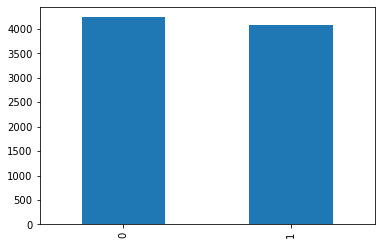

In [16]:
df.Change.value_counts().plot(kind = 'bar')

In [ ]:
# Null값 확인
df.isnull().sum()

In [17]:
# 한글과 공백을 제외하고 모두 제거
x_train['Title'] = x_train['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
x_train[:5]

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_4736/3316481079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  x_train['Title'] = x_train['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,Date,Change,Title
7223,2019-05-07,0,더벨힘 있는 에도 쏠리는 눈길 신한카드 신한페이판 매장결제 서비스 선봬 년 월 일 ...
5694,2014-09-24,0,대구 엑스코서 대중소기업 구매상담회
6213,2016-04-21,0,삼성전자 올 하반기 나노 공정 시스템반도체 생산 제일기획 분기 영업익 억작년보다 종...
7707,2020-09-29,0,아이델 끊임없는 혁신방음방탄 등 신소재 최고 도전 아모레 장녀보광 장남의 약혼식보다...
7089,2018-12-15,1,반도체 부터 스마트폰 까지삼성전자 보너스 차등 지급 코스피 보합권 등락 거듭코스닥 ...


In [18]:
# 한글이 없던 제목은 빈값이 됐을 것, Null로 변경
x_train['Title'] = x_train['Title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
x_train['Title'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

# Null값 없음
# test_data = test_data.dropna(how='any') # Null 값 제거


/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_4736/2262570851.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  x_train['Title'] = x_train['Title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


Date      0
Change    0
Title     0
dtype: int64


In [20]:

# 테스트 데이터도 같은 방식으로 전처리

x_test.drop_duplicates(subset = ['Title'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
x_test['Title'] = x_test['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
x_test['Title'] = x_test['Title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
x_test['Title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
x_test = x_test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(x_test))


전처리 후 테스트용 샘플의 개수 : 1664


/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_4736/178386575.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  x_test['Title'] = x_test['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_4736/178386575.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  x_test['Title'] = x_test['Title'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [22]:
x_test

,Date,Change,Title
4169,2010-03-09,0,국내 반도체 업체들 기지개 주가낮은 지금이 투자의 봄 만만원짜리 디지털 나온다 만...
7565,2020-05-04,0,이재용 대국민 사과에 삼성 그룹주 동반 급등 이재용 분 간 반성문 낭독도 허리 숙여...
6974,2018-08-12,0,년 지기 박근혜최순실 같은 날 심 선고 최강 스펙 갤노트 신형 아이폰 플래그십끼리...
2465,2005-07-08,0,유럽현대차 우선주 유럽 런던 테러속 등락 엇갈려 어봉투가 얇아졌네삼성 상반기 실적...
3378,2008-01-08,0,에어컨 시장 벌써 바람전쟁 공직 인맥 열전 정보통신부 삼성 영토 확장 나선다 삼...
...,...,...,...
4789,2012-01-13,1,삼성팬택 에 내는 로열티는 얼마 공급선 확대 본격화올 외판 비중 달할 듯 대...
4686,2011-08-31,1,삼성전자 세계 최대 메모리 라인 가동 삼성전자 세계 첫 나노급 램 양산 돌입 인터플...
7864,2021-03-19,0,프리미엄 무선청소기 삼성 비스포크 제트 삼성 주가만 왜속끓는 개미들 국내 주식 비중...
3781,2009-02-14,0,삼성 연구인력 수도권 이동 지역 정치권 강력대응 삼성 연구개발 인력 대거 수도권 이...


## 토큰화

In [23]:
# 불용어 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [24]:
okt = Okt()

In [25]:
# 토큰화를 위한 형태소 분석기, KoNLPy의 OKt 사용

X_train3 = []
for sentence in tqdm(x_train['Title']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train3.append(stopwords_removed_sentence)


100%|███████████████████████████████████████| 6656/6656 [21:14<00:00,  5.22it/s]


In [ ]:
# 테스트 데이터에 대해서도 동일하게 토큰화
'''
X_test = []
for sentence in tqdm(test_data['Title']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)
'''

In [27]:
# tokenizer 정보 저장

with open('X_train3.pickle','wb') as handle:
    pickle.dump(X_train3, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# tokenizer 저장 정보 불러오기

with open('X_train2.pickle', 'rb') as handle:
    X_train2 = pickle.load(handle)


In [ ]:
#tokenizer 저장 정보 불러오기

with open('X_test2.pickle', 'rb') as handle:
    X_test2 = pickle.load(handle)


In [ ]:
# 상위 3개 데이터 보기
print(X_train2[:3])
print(X_test2[:3])

## 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train2)

In [ ]:
# 단어 집합 생성과 함께 고유한 정수가 부여됨 / 등장 빈도수가 높은 순서대로 부여됨
print(tokenizer.word_index)

- 높은 점수 = 등장 빈도수 낮음

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중을 확인해보자

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt  - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train2)
X_train2 = tokenizer.texts_to_sequences(X_train2)
X_test2 = tokenizer.texts_to_sequences(X_test2)

- 정수 인코딩 잘 됐는지 확인

In [ ]:
print(X_train2[:3])

In [ ]:
y_train2 = np.array(train_data['Change'])
y_test2 = np.array(test_data['Change'])

## 빈 샘플 제거

In [ ]:
drop_train2 = [index for index, sentence in enumerate(X_train2) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train2 = np.delete(X_train2, drop_train2, axis=0)
y_train2 = np.delete(y_train2, drop_train2, axis=0)
print(len(X_train2))
print(len(y_train2))

## 패딩

In [ ]:
print('Title의 최대 길이 :',max(len(review) for review in X_train2))
print('Title의 평균 길이 :',sum(map(len, X_train2))/len(X_train2))
plt.hist([len(review) for review in X_train2], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
        

In [ ]:
max_len = 8000
below_threshold_len(max_len, X_train2)

In [ ]:
X_train2 = pad_sequences(X_train2, maxlen=max_len)
X_test2 = pad_sequences(X_test2, maxlen=max_len)

In [ ]:
X_train2


# LSTM 활용

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid')) # 만약 다중분류면 softmax 함수에, 3을 써줘야 한다

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['acc']) # categorical_crossentropy
history = model.fit(X_train2, y_train2, epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# 예측

- 현재 학습한 model에, 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용한다 
- model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()를 사용해야 한다

In [ ]:
def sentiment_predict(new_sentence):
      new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
      new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
      new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
      encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
      pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
      score = float(loaded_model.predict(pad_new)) # 예측
      if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
      else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))